In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import bisect

In [2]:
# Prepare the Data ---------------------------------------------------------------------

# ------------------------
# Load info
# ------------------------
info_df = pd.read_csv("info.csv")
fs = info_df.iloc[0, 5]                  # sampling frequency (Hz)
feature_names = info_df.iloc[:, 0].values

# ------------------------
# Load raw data
# ------------------------
baseline_df = pd.read_csv("baselinedataraw.csv")
baseline_time = baseline_df.iloc[:, 0].values            # time column (seconds)
baseline_data = baseline_df.iloc[:, 1:].values           # data columns

iBLend = math.ceil(0.1*baseline_data.shape[0])
baseline_time = baseline_time[:iBLend]
baseline_data = baseline_data[:iBLend, :]

df = pd.read_csv("dataraw.csv")
time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Determine outliers
# ------------------------
threshsd = 3 # standard deviations 
threshprop = .5 # proportion of features
BLmean = np.mean(baseline_data, axis=0)
BLstd = np.std(baseline_data, axis=0)
BLisout = np.abs(baseline_data - BLmean) > (threshsd * BLstd)
BLisnoise = np.sum(BLisout, axis=1) > (threshprop * baseline_data.shape[1])
isout = np.abs(data - BLmean) > (threshsd * BLstd)
isnoise = np.sum(isout, axis=1) > (threshprop * data.shape[1])

# ------------------------
# Load processed data
# ------------------------
baseline_df = pd.read_csv("baselinedata.csv")
baseline_time = baseline_df.iloc[:, 0].values            # time column (seconds)
baseline_data = baseline_df.iloc[:, 1:].values           # data columns

baseline_time = baseline_time[:iBLend]
baseline_data = baseline_data[:iBLend, :]

df = pd.read_csv("data.csv")
time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t, 1.2/fs) for t in time])
event_counts = event_counts.reshape(-1, 1)

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the _ ms rule
# ------------------------
dt_target = 0.005      # s
dt_tol = 0.15 * dt_target
seq_len = 64                   # samples
hzn_len = 1                   # samples
drow_target = int(dt_target * fs)  # number of rows 

X_list = []
Y_list = []

# create sliding windows
def create_windows(data, seq_len=128, horizon=1):
    X, Y = [], []
    for i in range(len(data) - seq_len - horizon + 1):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len + horizon - 1])
    return np.array(X), np.array(Y)

# --- baseline data ---
#Nbl = len(baseline_df)
Nbl = iBLend
for iStart in range(drow_target):
    inputs = []
    for i in range(iStart, (Nbl - drow_target), drow_target):
        dt = baseline_time[i+drow_target] - baseline_time[i]
        if (abs(dt - dt_target) <= dt_tol) and (not BLisnoise[i]):
            inputs.append(baseline_data[i, :]) 
        else:
            if len(inputs) > seq_len+hzn_len:
                x, y = create_windows(inputs, seq_len, hzn_len)
                if x is not None:
                    X_list.append(x)
                    Y_list.append(y)
            inputs = []
    # catch trailing segment
    if len(inputs) > seq_len+hzn_len:
        x, y = create_windows(inputs, seq_len, hzn_len)
        if x is not None:
            X_list.append(x)
            Y_list.append(y)

X = np.concatenate(X_list, axis=0)
Y = np.concatenate(Y_list, axis=0)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   
print("Output shape:", Y.shape)

num_feat = X.shape[-1]

# -----------------------------------------------------------------------------------------------


Pairs created: 118093
Input shape : torch.Size([118093, 64, 128])
Output shape: torch.Size([118093, 128])


In [3]:
# architecture for encoder-only, Hzn=1


def elu_feature_map(x):
    # FAVOR+ feature map
    return F.elu(x) + 1

class LinearAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        assert dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = dim // num_heads

        self.q_proj = nn.Linear(dim, dim)
        self.k_proj = nn.Linear(dim, dim)
        self.v_proj = nn.Linear(dim, dim)
        self.out_proj = nn.Linear(dim, dim)

    def forward(self, x):
        """
        x: (B, T, D)
        """
        B, T, D = x.shape

        # project to Q, K, V
        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        # reshape to multi-head
        q = q.view(B, T, self.num_heads, self.head_dim)
        k = k.view(B, T, self.num_heads, self.head_dim)
        v = v.view(B, T, self.num_heads, self.head_dim)

        # apply kernel feature map
        q = elu_feature_map(q)
        k = elu_feature_map(k)

        # normalize to avoid numerical issues
        eps = 1e-6

        # Compute KV = sum_t (phi(K_t) * V_t)
        # (B, num_heads, head_dim, head_dim)
        kv = torch.einsum("bthd,bthm->bhmd", k, v)

        # Compute normalizer: z = 1 / (sum_t phi(K_t) * 1)
        # (B, num_heads, head_dim)
        z = 1 / (torch.einsum("bthd,bhd->bth", q, k.sum(dim=1)) + eps)

        # Compute output: y_t = (phi(Q_t) * KV) * z_t
        # (B, T, num_heads, head_dim)
        out = torch.einsum("bthd,bhmd->bthm", q, kv)
        out = out * z.unsqueeze(-1)

        # merge heads
        out = out.reshape(B, T, D)

        return self.out_proj(out)

class LinearTransformerEncoderLayer(nn.Module):
    def __init__(self, dim_model, num_heads, dim_ff=128, dropout=0.1):
        super().__init__()

        self.attn = LinearAttention(dim_model, num_heads)
        self.norm1 = nn.LayerNorm(dim_model)
        self.dropout1 = nn.Dropout(dropout)

        self.ff = nn.Sequential(
            nn.Linear(dim_model, dim_ff),
            nn.ReLU(),
            nn.Linear(dim_ff, dim_model),
        )
        self.norm2 = nn.LayerNorm(dim_model)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        # Attention block
        attn_out = self.attn(x)
        x = self.norm1(x + self.dropout1(attn_out))

        # Feedforward block
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_out))

        return x


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, dim_model, max_len=5000):
        super().__init__()

        # Create matrix of shape (max_len, dim_model)
        pe = torch.zeros(max_len, dim_model)
        position = torch.arange(0, max_len).unsqueeze(1)  # (max_len, 1)

        # Divide by log-based frequencies
        div_term = torch.exp(torch.arange(0, dim_model, 2) * (-math.log(10000.0) / dim_model))

        # Apply sin to even indices, cos to odd
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register as buffer so it's saved with model but not trainable
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, dim_model)

    def forward(self, x):
        """
        x: (B, T, dim_model)
        returns: x + positional_encoding[:, :T, :]
        """
        T = x.size(1)
        return x + self.pe[:, :T, :]


class TimeSeriesTransformer(nn.Module):
    def __init__(self, dim_in, dim_out, pos_len=512, group_size=7, num_groups=7):
        super().__init__()

        # transformer properties
        dim_model=32
        num_heads=4
        num_layers=8
        dim_ff=128

        # time-independent preprocessing features -------------------------------------------
        
        C1 = 32
        C2 = 32

        self.num_groups = num_groups
        self.group_size = group_size
        self.num_pairs = num_groups * group_size  # 49
        self.used_for_pairing = self.num_pairs * 2
        self.leftover_dim = dim_in - self.used_for_pairing
        self.pair_output = 8

        # Stage 1: pairwise linear 
        self.pair_fc1 = nn.Linear(2, C1)  # like conv kernel_size=2
        self.pair_fc2 = nn.Linear(C1, self.pair_output)  # like conv kernel_size=1

        # Stage 2: linear over flattened group
        self.group_fcA = nn.Linear(group_size * self.pair_output, C2)
        self.group_fcB = nn.Linear(num_groups * self.pair_output, C2)
        # MLP input = 56 + 56 + leftover(3) = 115
        mlp_in = (num_groups * C2) + (group_size * C2) + self.leftover_dim

        # stage 3: a few MLP layers to get to dim_model
        self.fc1 = nn.Linear(mlp_in, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, dim_model)

        # ---------------------------------------------------------------------------------------

        # Positional embedding
        #self.pos_emb = nn.Parameter(torch.randn(1, pos_len, dim_model))
        self.pos_emb = SinusoidalPositionalEncoding(dim_model, max_len=pos_len)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_model,
            nhead=num_heads,
            dim_feedforward=dim_ff,
            activation='gelu',
            batch_first=True  # lets inputs be (B, T, D)
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # time convolution
        self.time_conv1 = nn.Conv1d(pos_len, 32, kernel_size=4, padding='same')
        self.time_conv2 = nn.Conv1d(32, 16, kernel_size=4, padding='same')
        self.time_conv3 = nn.Conv1d(16, 8, kernel_size=4, padding='same')
        self.time_conv4 = nn.Conv1d(8, 4, kernel_size=4, padding='same')
        self.time_fc = nn.Linear(4, 1)

        # Output head for next-step prediction ------------------------------------------------
        self.fco1 = nn.Linear(dim_model, 64)
        self.fco2 = nn.Linear(64, 64)
        self.fco3 = nn.Linear(64, 64)
        self.fco4 = nn.Linear(64, dim_out)

    def forward(self, x):
        """
        x: (B, T, dim_in)
        """
        if x.ndim != 3:
            raise ValueError(f"Expected input ndim=3, got {x.ndim}")
        T = x.size(1)
        #if T > self.pos_emb.size(1):
        #    raise RuntimeError(f"Sequence length T={T} exceeds pos_len={self.pos_emb.size(1)}. "
        #                       "Either increase pos_len or ensure inputs have smaller T.")
        #x = self.input_proj(x) + self.pos_emb[:, :T, :]
        B = x.size(0)

        x_left = x[:, :, self.used_for_pairing:]  # (B,T,3)
        x_used = x[:, :, :self.used_for_pairing]  # (B, 100)
        x_pairs = torch.stack( 
            (
                x_used[:, :, :self.num_pairs],            # x[0..49]
                x_used[:, :, self.num_pairs:],             # x[49..100]
            ),
            dim=3
        )  # (B,T,49,2)

        # Stage 1
        p = F.gelu(self.pair_fc1(x_pairs))     # (B,T,49,8)
        p = F.gelu(self.pair_fc2(p))           # (B,T,49,2)

        # Stage 2A: groups
        p_groups = p.view(B, T, self.num_groups, self.group_size * self.pair_output)  # (B,T,7,14)
        a = F.gelu(self.group_fcA(p_groups))                      # (B,T,7,8)
        a_flat = a.view(B, T, -1)                                 # (B,T,56)

        # Stage 2B: threads
        p_threads = p.view(B, T, self.num_groups, self.group_size, self.pair_output)   # (B,T,7,7,2)
        p_threads = p_threads.permute(0,1,3,2,4).contiguous()           # (B,T,7,7,2)
        p_threads = p_threads.view(B, T, self.group_size, -1)            # (B,T,7,14)
        b = F.gelu(self.group_fcB(p_threads))                         # (B,T,7,8)
        b_flat = b.view(B, T, -1)                                        # (B,T,56)

        # Stage 3 MLP
        h = torch.cat([a_flat, b_flat, x_left], dim=2)        # (B,T,115)
        h = F.gelu(self.fc1(h))
        h = F.gelu(self.fc2(h))
        h = F.gelu(self.fc3(h))
        h = F.gelu(self.fc4(h))
        h = F.gelu(self.fc5(h))

        # Transformer --------------------------------------------------------------------

        h = self.pos_emb(h)
        z = self.encoder(h)

        # time convolution
        #z = z.permute(0, 2, 1)  # (B, dim_model, T)
        z = F.gelu(self.time_conv1(z))
        z = F.gelu(self.time_conv2(z))
        z = F.gelu(self.time_conv3(z))
        z = F.gelu(self.time_conv4(z))
        z = z.permute(0, 2, 1)  # (B, T, 1)
        z = F.gelu(self.time_fc(z))

        # Output head --------------------------------------------------------------------
        y = z[:, :, -1]  # (B, dim_model)
        y = F.gelu(self.fco1(y))
        y = F.gelu(self.fco2(y))
        y = F.gelu(self.fco3(y))
        out = self.fco4(y)  # (B, dim_out)
        return out


In [4]:
# architecture for seq2seq

# ----------------------------
# Helper: causal mask for decoder
# ----------------------------
def generate_square_subsequent_mask(sz: int, device: torch.device):
    """Upper-triangular mask with 0 on and below diagonal, -inf above to mask future tokens."""
    mask = torch.triu(torch.ones((sz, sz), device=device), diagonal=1).bool()
    # nn.Transformer modules expect float mask with -inf for masked positions if using add_mask
    # but when using boolean mask arguments (src_key_padding_mask / tgt_key_padding_mask) behavior differs.
    # We'll return a float mask suitable for use in `attn_mask` (additive).
    attn_mask = torch.full((sz, sz), float('-inf'), device=device)
    attn_mask[~mask] = 0.0
    return attn_mask  # shape (sz, sz)


# ----------------------------
# Seq2Seq Transformer Model
# ----------------------------
class Seq2SeqTimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        dim_in,         # number of input features (all features present in encoder input)
        dim_out,        # number of features to predict (subset of dim_in)
        seq_len=64,
        horizon=32,
        dim_model=32,
        num_heads=2,
        num_encoder_layers=2,
        num_decoder_layers=2,
        dim_ff=64,
        dropout=0.1,
        #max_positional_len=5000,
        device=torch.device('cpu'),
    ):
        super().__init__()
        self.device = device
        self.seq_len = seq_len
        self.horizon = horizon
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.dim_model = dim_model

        # 1) Input projection: map raw input features -> model dimension
        self.input_proj = nn.Linear(dim_in, dim_model)

        # 2) Positional embeddings (learned)
        #self.pos_emb_enc = nn.Parameter(torch.randn(1, max_positional_len, dim_model))
        #self.pos_emb_dec = nn.Parameter(torch.randn(1, max_positional_len, dim_model))
        # sinusoidal positional embeddings
        self.pos_emb_enc = SinusoidalPositionalEncoding(dim_model, max_len=seq_len)
        self.pos_emb_dec = SinusoidalPositionalEncoding(dim_model, max_len=horizon)

        # 3) Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_model,
            nhead=num_heads,
            dim_feedforward=dim_ff,
            batch_first=True,
            dropout=dropout,
            activation='gelu'
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # 4) Transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_model,
            nhead=num_heads,
            dim_feedforward=dim_ff,
            batch_first=True,
            dropout=dropout,
            activation='gelu'
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # 5) Output projection: map model dimension -> predicted features
        self.output_proj = nn.Linear(dim_model, dim_out)

        # optional: small linear to initialize first decoder input from encoder summary, if needed
        self.dec_init_proj = nn.Linear(dim_model, dim_model)

        self._reset_parameters()
        self.to(device)

    def _reset_parameters(self):
        # Initialization similar to PyTorch Transformer
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def encode(self, src):
        """
        src: (batch, seq_len, dim_in)
        returns: memory (batch, seq_len, dim_model)
        """
        b, t, _ = src.shape
        x = self.input_proj(src)                       # (b, t, dim_model)
        #x = x + self.pos_emb_enc[:, :t, :]             # add positional embedding
        x = self.pos_emb_enc(x)                        # add positional embedding
        memory = self.encoder(x)                       # (b, t, dim_model)
        return memory

    def decode(self, tgt, memory, tgt_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        """
        tgt: (batch, tgt_len, dim_model)  -- already projected + pos emb
        memory: encoder outputs (batch, src_len, dim_model)
        """
        out = self.decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask,
        )  # (b, tgt_len, dim_model)
        return out

    def forward(self, src, tgt_in):
        """
        Forward pass used in training with teacher forcing.

        src: (batch, seq_len, dim_in)
        tgt_in: (batch, tgt_len, dim_out) -- ground truth future sequence shifted right
                Example: if horizon = H and dim_out=F,
                tgt_in[:, 0, :] should be a start token (e.g., zeros)
                tgt_in[:, 1:, :] are ground-truth up to H-1 steps (teacher forcing).
        Returns:
            logits: (batch, tgt_len, dim_out)
        """
        device = src.device
        b, src_len, _ = src.shape
        _, tgt_len, _ = tgt_in.shape
        #assert src_len <= self.pos_emb_enc.shape[1], "increase max_positional_len"
        #assert tgt_len <= self.pos_emb_dec.shape[1], "increase max_positional_len"

        # 1) Encode
        memory = self.encode(src)  # (b, src_len, dim_model)

        # 2) Prepare decoder input embeddings: we project the provided tgt_in (dim_out) into dim_model
        #    Common pattern: during training, feed the true previous outputs (teacher forcing).
        #    Because tgt_in contains actual feature values (not model embeddings), we map them
        #    into model space with a small linear layer (re-using input_proj for simplicity if dims match).
        #    Here, to keep model flexible, we'll use a small linear (input_proj_dec) implemented on the fly.
        # Simple approach: expand dim_out -> dim_model with a linear
        # For simplicity re-use input_proj if dim_in == dim_out; otherwise make a quick linear on the fly:
        if self.dim_in == self.dim_out:
            # reuse input projection if dims align
            tgt_emb = self.input_proj(tgt_in)            # (b, tgt_len, dim_model)
        else:
            # lightweight linear mapping for decoder inputs (not saved as parameter to keep API simple)
            # but better to declare a module if used heavily; here we allocate on the fly for clarity
            # (we'll do a proper parametrized projection to avoid re-creating params each forward)
            if not hasattr(self, 'tgt_input_proj'):
                self.tgt_input_proj = nn.Linear(self.dim_out, self.dim_model).to(self.device)
            tgt_emb = self.tgt_input_proj(tgt_in)

        # add positional embeddings
        #tgt_emb = tgt_emb + self.pos_emb_dec[:, :tgt_len, :]
        tgt_emb = self.pos_emb_dec(tgt_emb)

        # 3) Create causal mask for decoder self-attention
        tgt_mask = generate_square_subsequent_mask(tgt_len, device=device)  # (tgt_len, tgt_len)

        # 4) Run decoder: decoder expects target embeddings + encoder memory
        dec_out = self.decode(
            tgt=tgt_emb,
            memory=memory,
            tgt_mask=tgt_mask,
        )  # (b, tgt_len, dim_model)

        # 5) Project decoder outputs to predicted feature space
        logits = self.output_proj(dec_out)  # (b, tgt_len, dim_out)
        return logits

    @torch.no_grad()
    def generate(self, src, horizon=None, start_token=None):
        """
        Autoregressive generation / inference.

        src: (batch, seq_len, dim_in)
        horizon: number of steps to generate (defaults to self.horizon)
        start_token: (dim_out,) or (batch, dim_out) initial token fed to decoder as t=0.
                     If None, zeros are used.

        Returns:
            generated: (batch, horizon, dim_out)
        """
        self.eval()
        device = src.device
        b = src.shape[0]
        horizon = self.horizon if horizon is None else horizon

        # 1) encode
        memory = self.encode(src)  # (b, src_len, dim_model)

        # 2) prepare initial decoder input (t=0)
        if start_token is None:
            cur_input = torch.zeros((b, 1, self.dim_out), device=device)  # (b, 1, dim_out)
        else:
            # allow vector or batch vector
            st = torch.tensor(start_token, device=device, dtype=src.dtype)
            if st.dim() == 1:
                st = st.unsqueeze(0).expand(b, -1)
            cur_input = st.unsqueeze(1)  # (b, 1, dim_out)

        generated = []
        # autoregressive loop
        for t in range(horizon):
            # build tgt_in as the sequence of already generated tokens for this batch
            if len(generated) == 0:
                tgt_in = cur_input  # (b, 1, dim_out)
            else:
                # stack previously generated tokens
                prev = torch.cat(generated, dim=1)  # (b, t, dim_out)
                tgt_in = torch.cat([cur_input, prev], dim=1)  # (b, t+1, dim_out)

            # forward through model (teacher forcing not applied)
            logits = self.forward(src, tgt_in)  # (b, t+1, dim_out)
            # take the last step's predictions as next token
            next_token = logits[:, -1:, :]  # (b, 1, dim_out)
            generated.append(next_token)

            # note: optional sampling or temperature can be applied here for stochastic outputs

        gen = torch.cat(generated, dim=1)  # (b, horizon, dim_out)
        return gen

In [5]:
# Initialize the Model, Loss Function, and Optimizer

test_size=0.8
batch_size = 32

groupsize = 16

model = TimeSeriesTransformer(dim_in=num_feat, dim_out=num_feat, pos_len=seq_len, group_size=groupsize, num_groups=4)
#model = Seq2SeqTimeSeriesTransformer(dim_in=num_feat, dim_out=num_feat, seq_len=seq_len, horizon=hzn_len, dim_model=8, num_heads=2, num_encoder_layers=2, num_decoder_layers=2, dim_ff=16)
criterion = nn.MSELoss()

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=42)
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
all_loader = DataLoader(TensorDataset(X, Y), shuffle=False)

In [6]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?

Train samples: 23618
Batch size: 32
Batches/epoch: 739
Epoch 1/100 — train_loss: 95.949166, val_loss: 95.650352
Epoch 2/100 — train_loss: 95.949063, val_loss: 95.650325
Epoch 3/100 — train_loss: 95.948868, val_loss: 95.650688
Epoch 4/100 — train_loss: 95.949108, val_loss: 95.650422
Epoch 5/100 — train_loss: 95.948874, val_loss: 95.650334
Epoch 6/100 — train_loss: 95.948964, val_loss: 95.650281
Epoch 7/100 — train_loss: 95.948829, val_loss: 95.650348
Epoch 8/100 — train_loss: 95.948899, val_loss: 95.650298
Epoch 9/100 — train_loss: 95.949219, val_loss: 95.650564
Epoch 10/100 — train_loss: 95.949098, val_loss: 95.650317
Epoch 11/100 — train_loss: 95.948988, val_loss: 95.650371
Epoch 12/100 — train_loss: 95.948834, val_loss: 95.650336
Epoch 13/100 — train_loss: 95.948732, val_loss: 95.650333
Epoch 14/100 — train_loss: 95.948941, val_loss: 95.650335
Epoch 15/100 — train_loss: 95.948713, val_loss: 95.650825
Epoch 16/100 — train_loss: 95.948977, val_loss: 95.650629
No improvement for 10 epoc

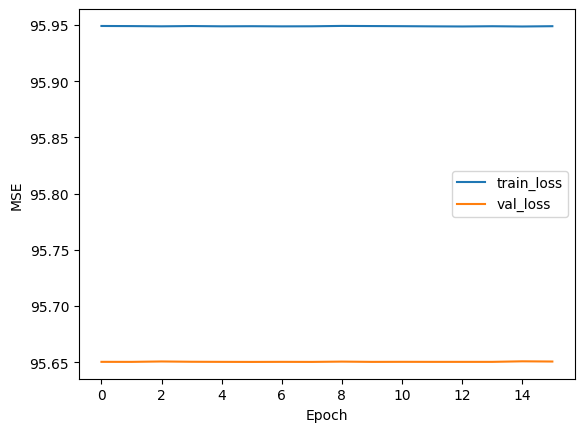

In [9]:
# Step 4: Train the Model
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 10
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} — train_loss: {epoch_train_loss:.6f}, val_loss: {epoch_val_loss:.6f}")

    # --- Early stopping ---
    if epoch_val_loss < best_val - 1e-9:
        best_val = epoch_val_loss
        no_improve = 0
        # Optionally save best model:
        # torch.save(model.state_dict(), "neural_network_pytorch.pth")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"No improvement for {patience} epochs — stopping early at epoch {epoch+1}.")
            break

# After loop: plot train/val loss to inspect convergence
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [10]:
# load or save model
# model.load_state_dict(torch.load("neural_network_pytorch.pth"))
# torch.save(model.state_dict(), "neural_network_pytorch.pth")

Test Loss: 95.6506


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (9).

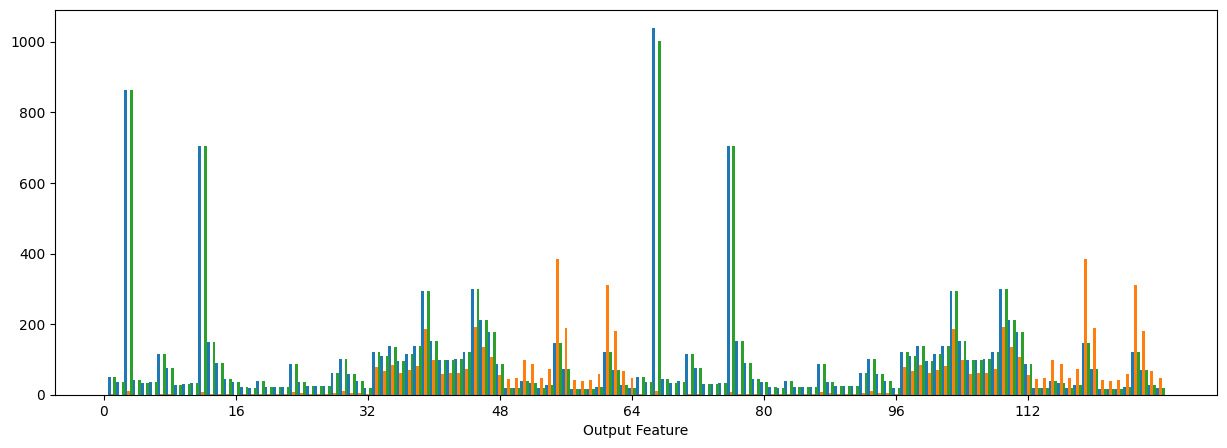

In [11]:
# Step 5: Evaluate the Model on Test Data

Y_pred = []
Y_test1 = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch in test_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        if y_pred.shape[0] == batch_size:
            Y_pred.append(y_pred)
            Y_test1.append(y_batch)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_pred_np = np.array(Y_pred)
Y_pred_np = Y_pred_np.reshape(-1, num_feat)
Y_test_np = Y_test.numpy()
Y_test1_np = np.array(Y_test1)
Y_test1_np = Y_test1_np.reshape(-1, num_feat)

Y_null_all_np = X.numpy()[:, -1, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, -1, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test1_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.xticks(ticks=range(0, len(feats), groupsize), labels=feature_names[::groupsize], rotation=90, ha='right')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

MSE_per_feat = MSE_per_feat / np.mean(Y_test1_np**2, axis=0)
MSE_per_feat_null = MSE_per_feat_null / np.mean(Y_test_np**2, axis=0)

In [12]:
X_all_np = X.numpy()
Y_all_np = Y.numpy()

Y_all_pred = []

model.eval()
with torch.no_grad():
    total_loss = 0
    for x_batch, y_batch in all_loader:
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        total_loss += loss.item() * x_batch.size(0)  # sum up batch loss
        Y_all_pred.append(y_pred)

    avg_loss = total_loss / len(test_dataset)
    print(f"Test+Train Loss: {avg_loss:.4f}")

Y_pred_all_np = np.array(Y_all_pred)
Y_pred_all_np = Y_pred_all_np.reshape(-1, num_feat)

Test+Train Loss: 119.6367


In [13]:
# simulations 
simdur = int(0.2 * fs) # samples 
plotdomain = 1000 * np.array([-1, 1]) + train_N

Ysim = []
i0 = plotdomain[0]
model.eval()
while i0+simdur < plotdomain[1]:
    xi = torch.tensor(X_all_np[i0, :, :].reshape(1,-1,num_feat), dtype=torch.float32)
    for i in range(simdur):
        with torch.no_grad():
            yi = model(xi).numpy().flatten()
        Ysim.append(yi)
        # prepare next input
        if i < simdur - 1:
            #event_count_next = X_all_np[i0 + i + 1, -1]  # keep using original event count
            #xi = torch.tensor(np.hstack([yi, event_count_next]).reshape(1, -1), dtype=torch.float32)
            xi = torch.tensor(np.vstack([xi[0, 1:, :], yi]).reshape(1,-1,X.shape[-1]), dtype=torch.float32)
    i0 += simdur
    print("Simulating:", (i0-plotdomain[0])/(plotdomain[1]-plotdomain[0]), " complete." )

Ysim = np.array(Ysim)
plotxval = np.arange(len(Ysim)) + plotdomain[0]

Simulating: 0.1  complete.
Simulating: 0.2  complete.
Simulating: 0.3  complete.
Simulating: 0.4  complete.
Simulating: 0.5  complete.
Simulating: 0.6  complete.
Simulating: 0.7  complete.
Simulating: 0.8  complete.
Simulating: 0.9  complete.


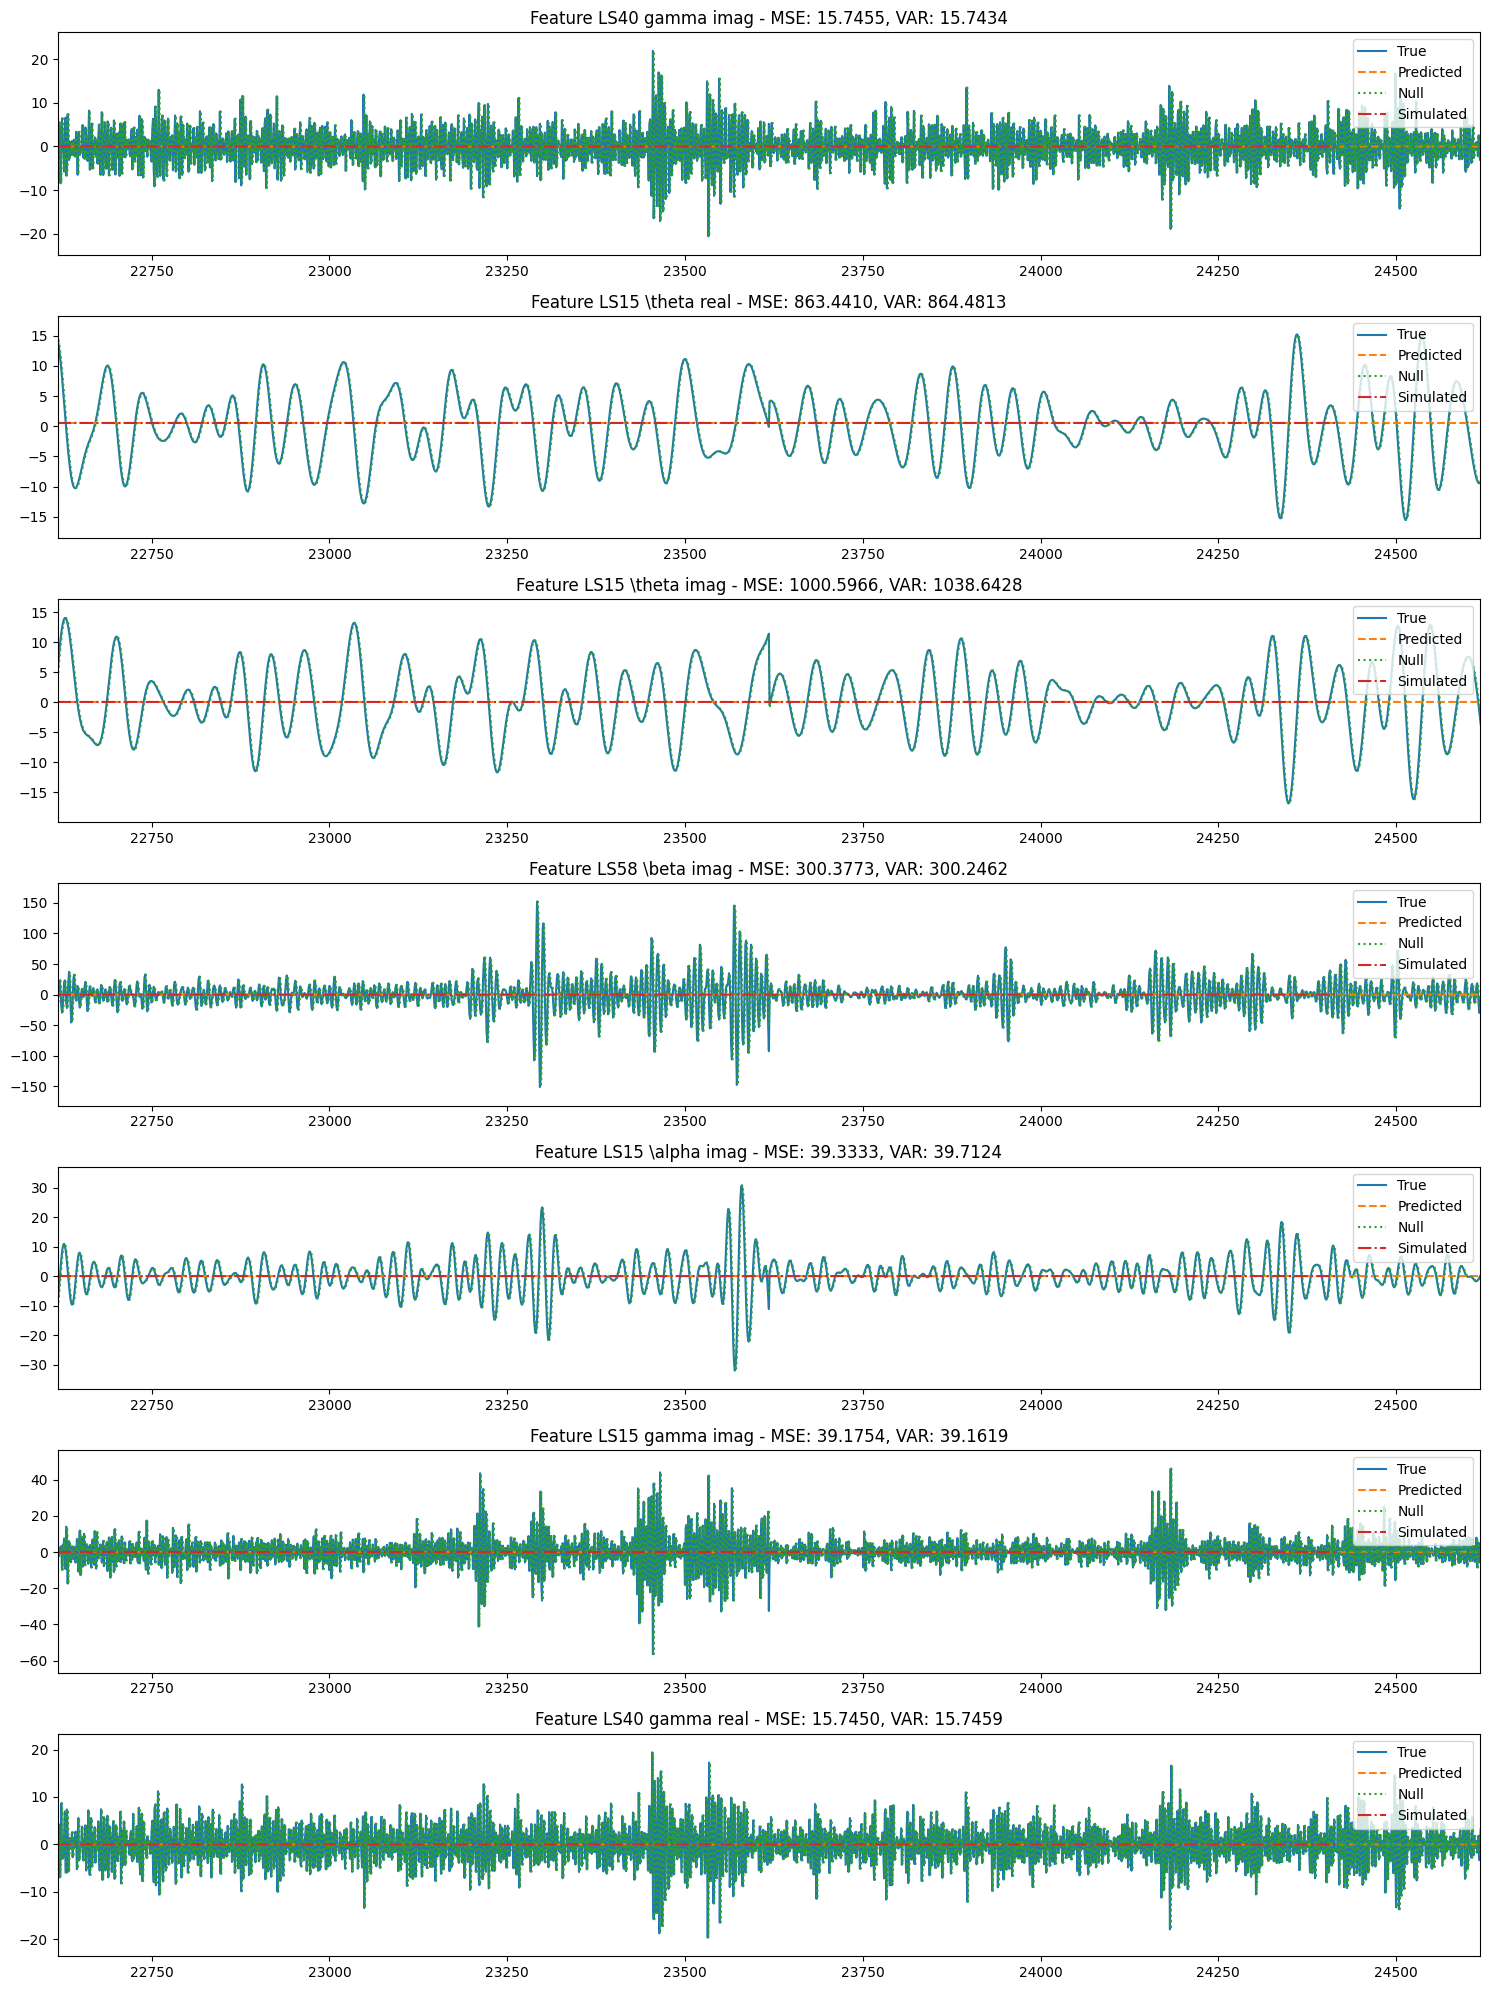

In [14]:
# show several examples 

iMSE = np.argsort(MSE_per_feat)
iVAR = np.argsort(var_per_feat)
iLRN = np.argsort(MSE_per_feat / var_per_feat)
iToPlot = [iMSE[:2], iMSE[-2:], iVAR[:2], iVAR[-2:], iLRN[:2], iLRN[-2:]]
iToPlot = list(set([i for sublist in iToPlot for i in sublist]))

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.plot(plotxval, Ysim[:,i], label='Simulated', linestyle='-.')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {feature_names[i]} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend(loc='upper right')
    iPlot += 1
plt.tight_layout()
plt.show()